In [1]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import PIL
import read_datasets as rd
import constants as CONST
from importlib import reload
reload(rd)
reload(CONST)
import pickle

In [2]:
import sys
sys.path.insert(0, "/home/xiaoyuz1/mnist-em-bmm-gmm")
import gmm

from IPython.display import SVG, display
import svgwrite # conda install -c omnia svgwrite=1.1.6

In [3]:
from tqdm import tqdm
import time 
import collections

In [4]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [5]:
import cluster_stroke
reload(cluster_stroke)
from cluster_stroke import view_cluster, read_file, read_files

import process_strokes
reload(process_strokes)
from process_strokes import process_to_image

# Prepare features and Clustering

## From: https://github.com/magenta/magenta-demos/blob/main/jupyter-notebooks/Sketch_RNN.ipynb

In [ ]:

def get_bounds(data, factor=10):
    """Return bounds of data."""
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in range(len(data)):
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)

    return (min_x, max_x, min_y, max_y)

def draw_strokes(data, factor=1, svg_filename = '/raid/xiaoyuz1/sample.svg'):
    # tf.gfile.MakeDirs(os.path.dirname(svg_filename))
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    
    dims = (50 + max_x - min_x, 50 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))
    
    lift_pen = 1
    abs_x = 25 - min_x 
    abs_y = 25 - min_y
    
    p = "M%s,%s " % (abs_x, abs_y)
    command = "m"
    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
            
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        lift_pen = data[i, 2]
        p += command+str(x)+","+str(y)+" "
        
    the_color = "black"
    stroke_width = 1
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
    # dwg.save()
    display(SVG(dwg.tostring()))

In [ ]:
# drawing_idx = 129
# draw_strokes(drawing_npz['train'][drawing_idx])

## process raw QuickDraw format

In [16]:
def process_quickdraw_to_stroke(drawing_raw, side=28, b_spline_degree=3, b_spline_num_sampled_points=100):
    drawing_raw = np.asarray(drawing_raw)
    drawing_raw[:,0] = np.cumsum(drawing_raw[:,0], 0) + 25
    drawing_raw[:,1] = np.cumsum(drawing_raw[:,1], 0) + 25
    pen_lift_indices = np.where(drawing_raw[:,2] == 1)[0]+1
    strokes = np.vsplit(drawing_raw[:,:2].astype(float), pen_lift_indices)[:-1]
    
    strokes_normalized = strokes
    strokes_spline_fitted = []
    for stroke in strokes_normalized:
        stroke_sampled = rd.bspline(stroke, n=b_spline_num_sampled_points, degree=b_spline_degree)
        strokes_spline_fitted.append(stroke_sampled)
    
    return strokes_spline_fitted

In [7]:
path = "/raid/xiaoyuz1/sketch_datasets/SketchX-PRIS-Dataset/Perceptual Grouping/face.ndjson"
# drawing_npz = np.load(args.path, allow_pickle=True,encoding='latin1')
# drawing_arr = drawing_npz['train']
drawing_arr = json.load(open(path, 'r'))['train_data']

In [17]:
strokes_spline_fitted = process_quickdraw_to_stroke(drawing_arr[0])

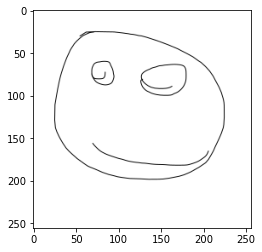

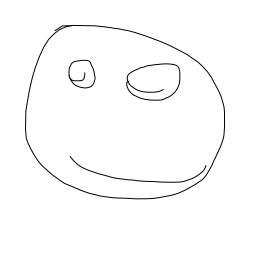

In [22]:
strokel = [strokes_spline_fitted[3]]
rd.render_img(
    strokes_spline_fitted, 
    #img_path='/raid/xiaoyuz1/stroke_images/QuickDrawFace_{}.png'.format(i), 
    show=True,
    side=256,
    line_diameter=1,
    padding=0,
    bg_color=(0,0,0),
    fg_color=(1,1,1),
    original_side = 256.,
    convert = True,
)

In [ ]:
all_stroke_img = []
for i in tqdm(range(len(all_stroke_data))):
    stroke = all_stroke_data[i]
    stroke_image = rd.render_img(
        [stroke], 
        #img_path='/raid/xiaoyuz1/stroke_images/QuickDrawFace_{}.png'.format(i), 
        show=True,
        side=28,
        line_diameter=1,
        padding=0,
        bg_color=(0,0,0),
        fg_color=(1,1,1),
        original_side = 28.,
        convert = True,
    )
    arr = np.array(stroke_image)
    all_stroke_img.append(arr)

In [ ]:
# draw entire face stroke
# strokes = rd.quickdraw_to_vector(drawing_npz['train'][2])
# rd.render_img(
#     strokes, 
#     img_path=None, 
#     show=False,
#     side=256,
#     line_diameter=1,
#     padding=0,
#     bg_color=(0,0,0),
#     fg_color=(1,1,1),
#     original_side = 256.,
#     convert = True,
# )

## Fitting b-spline

In [ ]:
# import numpy as np
# import scipy.interpolate as si
# import matplotlib.pyplot as plt
# colors = ('b', 'g', 'r', 'c', 'm', 'y', 'k')

# cv = strokes_normalized[4]
# # cv = np.vstack([cv, cv[0].copy()])
# plt.subplot(1, 2, 1)
# plt.plot(cv[:,0],cv[:,1], label='Control Points')
# plt.minorticks_on()
# # plt.legend()
# plt.xlabel('x')
# plt.ylabel('y')
# plt.xlim(0, 28)
# plt.ylim(28, 0)
# plt.gca().set_aspect('equal', adjustable='box')

# d = 3
# p = rd.bspline(cv,n=100,degree=d)
# x,y = p.T
# plt.subplot(1, 2, 2)
# plt.plot(x,y,label='Degree %s'%d,color = colors[d%len(colors)])

# plt.minorticks_on()
# plt.xlabel('x')
# plt.ylabel('y')
# plt.xlim(0, 28)
# plt.ylim(28, 0)
# plt.gca().set_aspect('equal', adjustable='box')
# plt.show()

## Raw pixel images

In [ ]:
def normalize_float_image(feat):
    value_min = feat.min()
    value_max = feat.max()
    feat = (feat - value_min) / (value_max - value_min)
    feat = feat * 255
    feat = feat.astype(np.uint8).reshape((28,28))
    return PIL.Image.fromarray(feat).resize((128,128))

In [ ]:
stroke_data = np.load(
    #'/raid/xiaoyuz1/QuickDrawFace-28-3-100-0-70000.npz',
    '/raid/xiaoyuz1/SPGFace-28-3-100-0-800.npz',
    allow_pickle=True,
    encoding='latin1',
)['train']

In [ ]:
all_stroke_data = np.vstack(stroke_data)
print(all_stroke_data.shape)

In [ ]:
stroke_data = np.load(
    '/raid/xiaoyuz1/QuickDrawFace-28-3-100-0-70000.npz',
    allow_pickle=True,
    encoding='latin1',
)['train']
process_to_image(stroke_data, 28, 28, '/raid/xiaoyuz1/QuickDrawFace-28-3-100-0-70000-image')

In [ ]:
all_stroke_img = []
for i in tqdm(range(len(all_stroke_data))):
    stroke = all_stroke_data[i]
    stroke_image = rd.render_img(
        [stroke], 
        #img_path='/raid/xiaoyuz1/stroke_images/QuickDrawFace_{}.png'.format(i), 
        show=False,
        side=28,
        line_diameter=1,
        padding=0,
        bg_color=(0,0,0),
        fg_color=(1,1,1),
        original_side = 28.,
        convert = True,
    )
    arr = np.array(stroke_image)
    all_stroke_img.append(arr)

In [ ]:
np.savez_compressed('/raid/xiaoyuz1/QuickDrawAngel-28-3-100-0-70000-image', data=np.asarray(all_stroke_img))

In [ ]:
features = read_files([
    '/raid/xiaoyuz1/QuickDrawFace-28-3-100-0-70000-image.npz'
])

In [ ]:
features_binary = np.where(features > 254, 0, 1)

In [ ]:
pca_dim = 40

if pca_dim >= 0:
    reducer = PCA(n_components=pca_dim, random_state=22)
    reducer.fit(features_binary)
    features_reduced = reducer.transform(features_binary)
else:
    features_reduced = features_binary

In [ ]:
# double checking the correctness of PCA
PIL.Image.fromarray(features[145].astype(np.uint8).reshape((28,28))).resize((128,128))

In [ ]:
normalize_float_image(reducer.inverse_transform(features_reduced[145]))

In [ ]:
print("Calculating clusters...")
num_cluster = 100
start_time = time.time()
model = KMeans(n_clusters=num_cluster, random_state=22)
model.fit(features_reduced)
print("[DONE] KMeans:", "--- %s seconds ---" % (time.time() - start_time))

In [ ]:
# save kmeans model
model_save_path = '/raid/xiaoyuz1/QuickDrawAngel-28-3-100-0-70000-pca40-kmeans100.pkl'
    
with open(model_save_path, "wb+") as f:
    pickle.dump(model, f)

In [ ]:
import collections
clusters = collections.defaultdict(list)
for image_idx, cluster_idx in zip(np.arange(len(features)), model.labels_):
    clusters[cluster_idx].append(image_idx)

In [ ]:
# create folder to save cluster images
visualize_save_folder = '/raid/xiaoyuz1/QuickDrawFace-28-3-100-pcano-kmeans100'
os.mkdir(visualize_save_folder)

In [ ]:
# visulize 100 strokes from each cluster
import cluster_stroke
reload(cluster_stroke)
from cluster_stroke import view_cluster

for cluster_idx in tqdm(np.unique(model.labels_)):
    image_indices = clusters[cluster_idx]
    save_path = os.path.join(visualize_save_folder, f'{cluster_idx}.png')
    view_cluster(features, image_indices, 1, canvas_size=28, save_path=save_path)

In [14]:
# load kmeans model from file

model_file_path = '/raid/xiaoyuz1/QuickDrawFace-28-3-100-pcano-kmeans50.pkl'

with open(model_file_path, 'rb') as file:
    model = pickle.load(file)

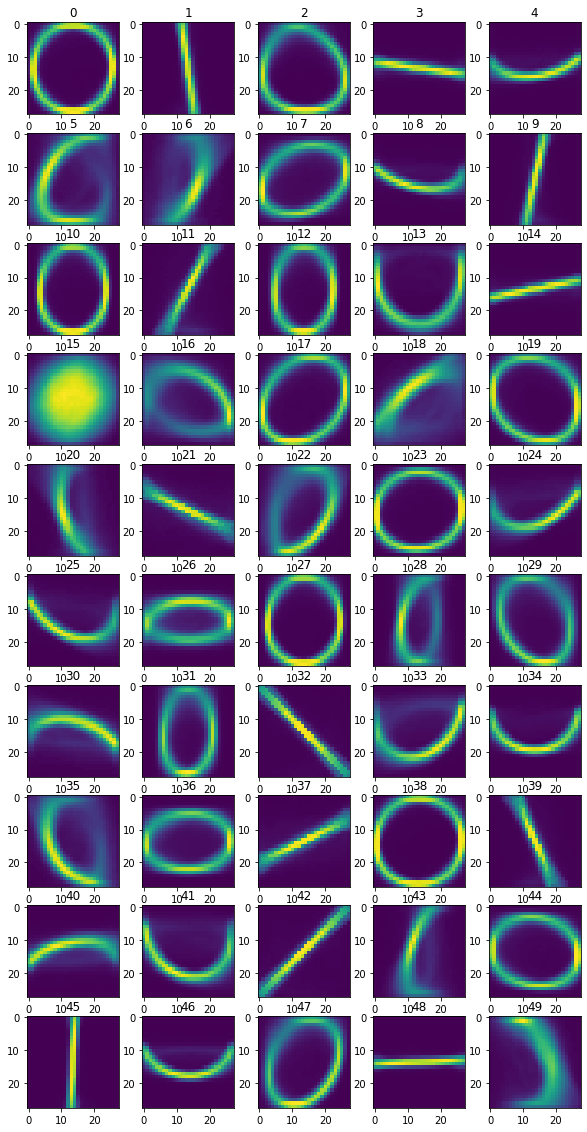

In [7]:
# examine cluster center 
import visualize
reload(visualize)

### project cluster center back to original dimension if needed 
# means_projected = reducer.inverse_transform(model.cluster_centers_)

visualize.plot_means(model.cluster_centers_)

Primitives (vectors)
Transformation (matrices)

Distribution of error by class
Language --> predict primitives --> predict transformation

Granularity of concepts

In [8]:
test_features = read_files(['/raid/xiaoyuz1/SPGFace-28-3-100-0-800-image.npz'])

Feature array dimension:  (4686, 784)


In [9]:
# test_features_reduced = reducer.transform(test_features)
features_binary = np.where(test_features > 254, 0, 1)
test_features_reduced = features_binary
labels = model.predict(test_features_reduced)

In [10]:
test_clusters = collections.defaultdict(list)
for image_idx, cluster_idx in zip(np.arange(len(test_features_reduced)), labels):
    test_clusters[cluster_idx].append(image_idx)

In [16]:
# how to add title to the subplots so that it shows captions
# mapping stroke index to image index
# acc = 0
# stroke_idx_to_image_idx = collections.defaultdict(int)
# for image_idx, stroke in enumerate(stroke_data):
#     for stroke_idx_in_image in range(len(stroke)):
#         stroke_idx_to_image_idx[acc] = (image_idx, stroke_idx_in_image)
#         acc += 1

def stroke_omit(drawing_raw, pen_lift_indices):
    
    drawing_raw[:,0] = np.cumsum(drawing_raw[:,0], 0)
    drawing_raw[:,1] = np.cumsum(drawing_raw[:,1], 0)
    pen_lift_indices = pen_lift_indices+1
    strokes = np.vsplit(drawing_raw[:,:2].astype(float), pen_lift_indices)[:-1]
    
    l = []
    
    for stroke in strokes:
        stroke = np.asarray(stroke).astype(float)
        min_x, min_y = np.min(stroke, 0)
        max_x, max_y = np.max(stroke, 0)
        side_x = max_x - min_x
        side_y = max_y - min_y
        if np.any(np.isclose(side_x, [1e-9, -1e-9])) or np.any(np.isclose(side_y, [1e-9, -1e-9])):
            l.append(False)
        else:
            l.append(True)
    return l

def stroke_idx_dicts(json_file):
    acc = 0
    d = collections.defaultdict(int)
    d2 = collections.defaultdict(int)
    
    for image_idx in tqdm(range(len(json_file))):
        drawing_raw = np.asarray(json_file[image_idx])
        pen_lift_indices = np.where(drawing_raw[:,2] == 1)[0]
        stroke_part_type = drawing_raw[:,3:4].astype(int)[pen_lift_indices].reshape(-1,)
        
        l = stroke_omit(drawing_raw, pen_lift_indices)
        
        stroke_idx_in_image = 0
        for _, (part_type, keep) in enumerate(zip(stroke_part_type, l)):
            if not keep:
                continue
            d[(image_idx, stroke_idx_in_image)] = part_type
            d2[acc] = (image_idx, stroke_idx_in_image)
            acc += 1
            stroke_idx_in_image += 1
    
    return d2,d

def get_titles(indices, dfo, sketch_category, stroke_idx_to_image_idxd, stroke_idx_to_partd):
    titles = []
    for idx in tqdm(indices):
        image_idx, stroke_idx_in_image = stroke_idx_to_image_idxd[idx]
        part_type = stroke_idx_to_partd[(image_idx, stroke_idx_in_image)]
        
        captions = dfo[(
            dfo['image_1'] == image_idx) & \
            (dfo['part'] == part_type) & \
            (dfo['category'] == sketch_category)]['no_punc_str_1'].to_list()
        
        if sketch_category == "face":
            part_name = CONST.face_parts_idx_dict[part_type]
        else:
            part_name = CONST.angel_parts_idx_dict[part_type]
        base_caption = f"{image_idx}-{part_name} "
        
        if len(captions) == 0:
            titles.append(base_caption)
        else:
            titles.append(base_caption + "\n".join(captions))
            
    return titles

In [17]:
d_face = stroke_idx_dicts(CONST.face_json['train_data'])
d_angel = stroke_idx_dicts(CONST.angel_json['train_data'])

dfo = pd.read_csv('/raid/xiaoyuz1/amazon_turk/df_all.csv')
dfo['no_punc_1'] = dfo.no_punc_1.apply(lambda x: [str(y).strip()[1:-1] for y in x[1:-1].split(',')])

100%|██████████| 800/800 [00:00<00:00, 1104.05it/s]


In [ ]:
stroke_data = np.load(
    #'/raid/xiaoyuz1/QuickDrawFace-28-3-100-0-70000.npz',
    '/raid/xiaoyuz1/SPGFace-28-3-100-0-800.npz',
    allow_pickle=True,
    encoding='latin1',
)['train']

In [19]:
print(len(d_face[0]), len(test_features))

4686 4686


100%|██████████| 89/89 [00:00<00:00, 708.93it/s]


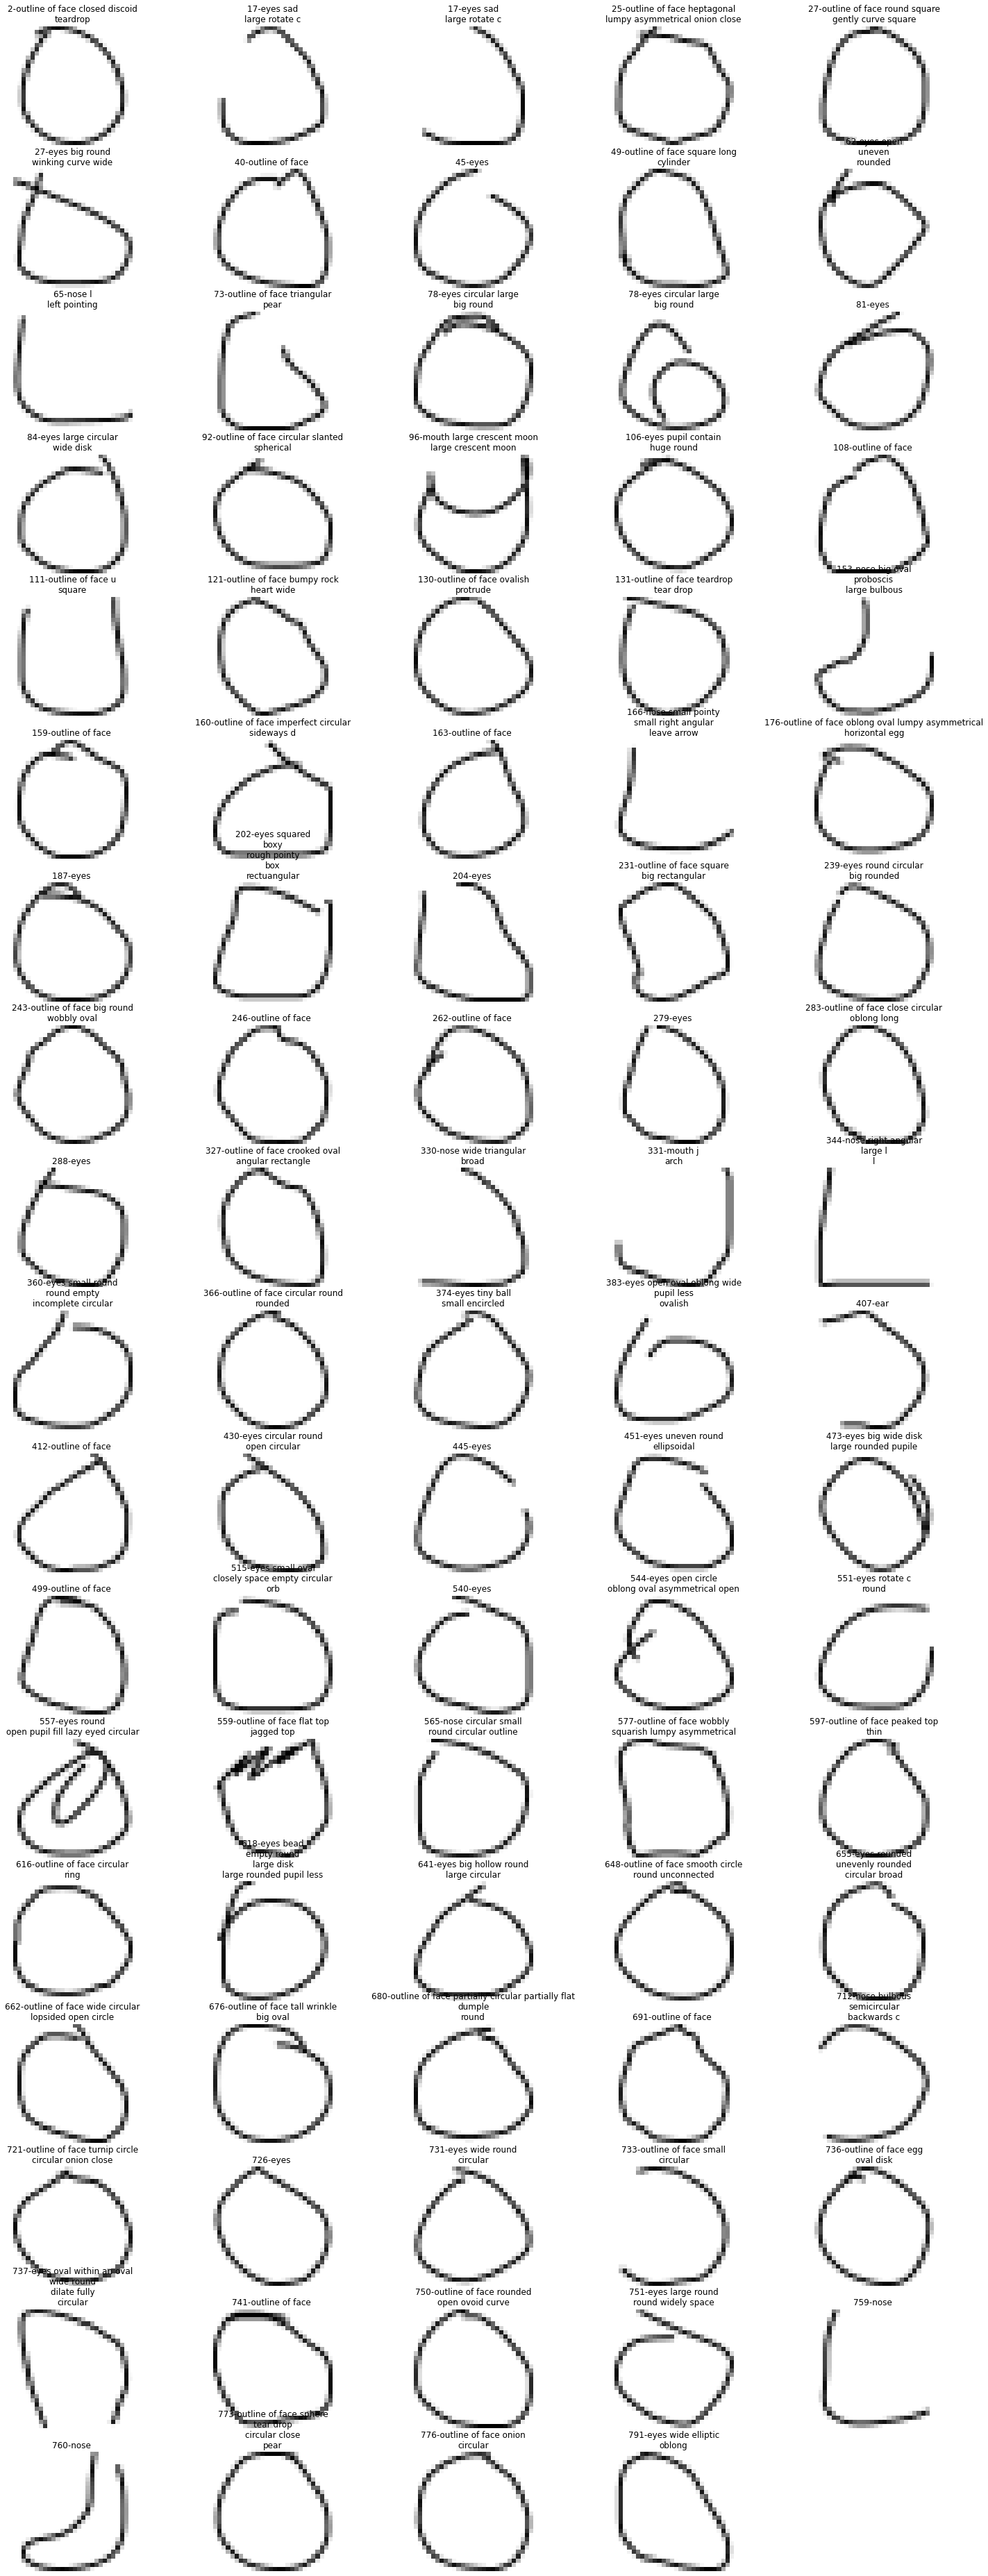

In [20]:
cluster_idx = 2
image_indices = test_clusters[cluster_idx]

if 'face' in model_file_path.lower():
    category = 'face'
    d1,d2 = d_face
else:
    category = 'angel'
    d1,d2 = d_angel

view_cluster(test_features, image_indices, 1, \
             titles = get_titles(image_indices, dfo, category, d1, d2), \
             canvas_size=28, save_path=None, show=True)

In [21]:
save_folder = model_file_path.split(".")[0]
save_folder.replace("QuickDraw", "SPG")
print("Save test cluster at: ", save_folder)
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
    
for cluster_idx in tqdm(np.unique(model.labels_)):
    image_indices = test_clusters[cluster_idx]
    save_path = os.path.join(save_folder, f'{cluster_idx}.png')
    
    if 'face' in save_folder.lower():
        category = 'face'
        d1,d2 = d_face
    else:
        category = 'angel'
        d1,d2 = d_angel
    
    view_cluster(test_features, image_indices, 1, \
                 titles = get_titles(image_indices, dfo, category, d1, d2), \
                 canvas_size=28, save_path=save_path)

Save test cluster at:  /raid/xiaoyuz1/QuickDrawFace-28-3-100-pcano-kmeans50


100%|██████████| 50/50 [02:05<00:00,  2.50s/it]


python cluster_stroke.py -path /raid/xiaoyuz1/QuickDrawFace-28-3-100-0-70000-image.npz \
    -pca_dim -1 -num_cluster 100 -image_format 1 -canvas_size 28 \
    -model_save_path /raid/xiaoyuz1/QuickDrawFace-28-3-100-pcano-kmeans100.pkl \
    -visualize_save_folder /raid/xiaoyuz1/QuickDrawFace-28-3-100-pcano-kmeans100
   
python cluster_stroke.py -path /raid/xiaoyuz1/QuickDrawFace-28-3-100-0-70000-image.npz \
    -pca_dim -1 -num_cluster 50 -image_format 1 -canvas_size 28 \
    -model_save_path /raid/xiaoyuz1/QuickDrawFace-28-3-100-pcano-kmeans50.pkl \
    -visualize_save_folder /raid/xiaoyuz1/QuickDrawFace-28-3-100-pcano-kmeans50

python cluster_stroke.py -path /raid/xiaoyuz1/QuickDrawFace-28-3-100-0-70000-image.npz \
    -pca_dim -1 -num_cluster 200 -image_format 1 -canvas_size 28 \
    -model_save_path /raid/xiaoyuz1/QuickDrawFace-28-3-100-pcano-kmeans200.pkl \
    -visualize_save_folder /raid/xiaoyuz1/QuickDrawFace-28-3-100-pcano-kmeans200

python cluster_stroke.py -path /raid/xiaoyuz1/QuickDrawAngel-28-3-100-0-70000-image.npz \
    -pca_dim -1 -num_cluster 100 -image_format 1 -canvas_size 28 \
    -model_save_path /raid/xiaoyuz1/QuickDrawAngel-28-3-100-pcano-kmeans100.pkl \
    -visualize_save_folder /raid/xiaoyuz1/QuickDrawAngel-28-3-100-pcano-kmeans100

python cluster_stroke.py -path /raid/xiaoyuz1/QuickDrawAngel-28-3-100-0-70000-image.npz \
    -pca_dim -1 -num_cluster 50 -image_format 1 -canvas_size 28 \
    -model_save_path /raid/xiaoyuz1/QuickDrawAngel-28-3-100-pcano-kmeans50.pkl \
    -visualize_save_folder /raid/xiaoyuz1/QuickDrawAngel-28-3-100-pcano-kmeans50

python cluster_stroke.py -path /raid/xiaoyuz1/QuickDrawAngel-28-3-100-0-70000-image.npz \
    -pca_dim -1 -num_cluster 200 -image_format 1 -canvas_size 28 \
    -model_save_path /raid/xiaoyuz1/QuickDrawAngel-28-3-100-pcano-kmeans200.pkl \
    -visualize_save_folder /raid/xiaoyuz1/QuickDrawAngel-28-3-100-pcano-kmeans200

## CLIP features

In [ ]:
feature_folder = '/raid/xiaoyuz1/stroke_features_face'

all_features = []
all_images = []

for file in tqdm(os.listdir(feature_folder)):
    if not file.endswith(".npy"):
        continue
        
    img_path = "{}.txt".format(file.split(".n")[0])
    feat = np.load(os.path.join(feature_folder, file))
    
    image_paths = None
    with open(os.path.join(feature_folder, img_path), 'r') as f:
        lines = f.readlines()
        image_paths = [line.strip() for line in lines]
        
    for feati,pathi in zip(feat,image_paths):
        all_features += [feati]
        all_images += [pathi]
features = np.vstack(all_features)
print(features.shape)

### Finding the right number of clusters for KMeans

In [ ]:
kmax = 30
pca_dim = 512

pca = PCA(n_components=pca_dim, random_state=22)
pca.fit(features)
x = pca.transform(features)

In [ ]:
sil = []
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(5, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(x)
    labels = kmeans.labels_
    sil.append(silhouette_score(x, labels, metric = 'euclidean'))

In [ ]:
sil

In [ ]:
plt.plot(range(5, kmax+1), sil)
plt.show()

In [ ]:
pca = PCA(n_components=512, random_state=22)
pca.fit(features)
x = pca.transform(features)

In [ ]:
kmeans = KMeans(n_clusters=20, random_state=22)
kmeans.fit(x)

In [ ]:
silhouette_score(x, kmeans.labels_, metric = 'euclidean')

In [ ]:
np.unique(kmeans.labels_)

In [ ]:
groups = {}
for file, cluster in zip(all_images, kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [ ]:
import PIL


In [ ]:
for k in np.unique(kmeans.labels_):
    print(k)
    view_cluster(k)

## Inception V3 features

# GMM clustering

# Visualize clusters